In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

logger = logging.getLogger(__name__)

### SETUP

In [2]:
# Load precomputed data

MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

initial_values['SM1A'] *= 1.01
initial_values['SM1B'] *= 1.008

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
# variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    # variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

objectives_active = {'LT': 'MAXIMIZE', 'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

# Manual modifications
initial_variable_values['SH1'] -= 0.2
initial_variable_values['SH3'] -= 0.08
initial_variable_values['SL2'] -= 0.5
initial_variable_values['SL3'] -= 0.5

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [3]:
reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

In [4]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

In [5]:
#TEST = True
TEST = False

if TEST:
    from opt_funcs_nsls import make_dummy_eval
    eval_f = make_dummy_eval(gvocs)
else:
    sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-26_APSU_DA_MA")
    import opt_funcs

    def knobs_to_family(inputs_dict):
        d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
        return opt_funcs.master_eval_function(d, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

    eval_f = knobs_to_family

In [6]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + 0.398 -> -4.385
SM1B: -5.231 + -0.447 -> -5.678
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.385288760620001,
 'SM1B': -5.6776103901960004,
 'SM2B': 7.2127339758749995}

In [7]:
if True:
    opt_funcs.master_eval_function(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

Sextupole adj. took 8.4.
RMS(dx, dy) [m] = (8.765e-05, 8.561e-06)
RMS(dx, dy) [m] = (5.373e-05, 6.685e-06)
RMS(dx, dy) [m] = (9.523e-05, 5.436e-06)
RMS(dx, dy) [m] = (6.258e-05, 9.195e-06)
RMS(dx, dy) [m] = (2.124e-05, 1.504e-06)
RMS(dx, dy) [m] = (2.643e-05, 2.079e-06)
RMS(dx, dy) [m] = (6.534e-06, 2.816e-06)
Orbit correction converged
** # of outliers found = 0 (out of 180)
Lifetime = 3.042 (raw tau [hr] = 3.731, epsy [pm] = 16.82) (took 5.2 [s])
Inj. Eff. = 37.16 (took 18.5 [s])
Eval. func. finished.


In [8]:
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
#gen.max_travel_distances = [0.1] * len(gvocs.variables_active)
gen.reference_point = reference_point

In [9]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

### Sample at initial values

In [10]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + -0.500 -> 6.636
SL3: -5.892 + -0.500 -> -6.392
SH1: 3.967 + -0.200 -> 3.767
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161
Sextupole adj. took 5.3.
RMS(dx, dy) [m] = (2.090e-04, 6.592e-06)
RMS(dx, dy) [m] = (2.040e-05, 3.995e-06)
RMS(dx, dy) [m] = (6.566e-05, 4.643e-06)
RMS(dx, dy) [m] = (8.740e-06, 1.328e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 3.786 (raw tau [hr] = 4.620, epsy [pm] = 16.63) (took 3.9 [s])
Inj. Eff. = 2.99 (took 15.0 [s])
Eval. func. finished.


In [11]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.0,-0.2,-0.08,0.0,0.0,-0.5,-0.5,"{'_nux': 0.2064655099190754, '_nuy': 0.2684310...",None,,...,True,0.206466,0.268431,2.228681e-09,1.670590e-11,2.242745e-09,1.662745e-11,3.785743,4.620131,2.992461


### Sample close to initial point

In [12]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + -0.008 -> -2.662
SL2: 7.136 + -0.502 -> 6.633
SL3: -5.892 + -0.496 -> -6.389
SH1: 3.967 + -0.188 -> 3.779
SH3: -1.171 + -0.082 -> -1.253
SH4: -3.164 + 0.011 -> -3.153
SM1A: -4.783 + -0.012 -> -4.795
SM1B: -5.231 + 0.013 -> -5.217
SM2B: 7.161 + -0.002 -> 7.159
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (3.401e-06, 9.484e-07)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 3.889 (raw tau [hr] = 4.739, epsy [pm] = 16.59) (took 3.9 [s])
Inj. Eff. = 1.64 (took 15.0 [s])
Eval. func. finished.


In [13]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,-0.200000,-0.080000,0.000000,0.000000,-0.500000,-0.500000,"{'_nux': 0.2064655099190754, '_nuy': 0.2684310...",None,,...,True,0.206466,0.268431,2.228681e-09,1.670590e-11,2.242745e-09,1.662745e-11,3.785743,4.620131,2.992461
2,0.017855,-0.187937,-0.081641,0.010791,-0.007804,-0.502309,-0.496378,"{'_nux': 0.205565248747958, '_nuy': 0.27068939...",None,,...,True,0.205565,0.270689,2.219011e-09,1.662855e-11,2.236210e-09,1.658763e-11,3.889114,4.738622,1.638109


### Run optimizer

In [14]:
opt.step()

/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:404: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


SL1: -2.654 + -0.145 -> -2.800
SL2: 7.136 + -0.483 -> 6.653
SL3: -5.892 + 0.149 -> -5.743
SH1: 3.967 + -0.055 -> 3.911
SH3: -1.171 + -0.106 -> -1.277
SH4: -3.164 + 0.238 -> -2.926
SM1A: -4.783 + -0.142 -> -4.926
SM1B: -5.231 + 0.160 -> -5.071
SM2B: 7.161 + -0.019 -> 7.142
Sextupole adj. took 7.4.
RMS(dx, dy) [m] = (3.573e-05, 2.602e-06)
RMS(dx, dy) [m] = (6.415e-05, 4.238e-06)
RMS(dx, dy) [m] = (1.474e-05, 2.736e-06)
RMS(dx, dy) [m] = (2.681e-05, 3.483e-06)
RMS(dx, dy) [m] = (7.464e-06, 1.103e-06)
Orbit correction converged
** # of outliers found = 6 (out of 180)
Lifetime = 4.989 (raw tau [hr] = 6.092, epsy [pm] = 16.67) (took 5.0 [s])
Inj. Eff. = 33.29 (took 17.8 [s])
Eval. func. finished.


In [15]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()


** Step #1 at 2023-11-26 21:42:59**

SL1: -2.654 + -0.185 -> -2.839
SL2: 7.136 + -0.478 -> 6.658
SL3: -5.892 + 0.380 -> -5.512
SH1: 3.967 + -0.017 -> 3.950
SH3: -1.171 + -0.113 -> -1.284
SH4: -3.164 + 0.303 -> -2.861
SM1A: -4.783 + -0.180 -> -4.964
SM1B: -5.231 + 0.202 -> -5.029
SM2B: 7.161 + -0.024 -> 7.137
Sextupole adj. took 2.2.
RMS(dx, dy) [m] = (2.648e-05, 1.064e-06)
RMS(dx, dy) [m] = (1.360e-05, 5.033e-06)
RMS(dx, dy) [m] = (9.585e-06, 2.196e-06)
Orbit correction converged
** # of outliers found = 9 (out of 180)
Lifetime = 5.321 (raw tau [hr] = 6.602, epsy [pm] = 17.15) (took 8.6 [s])
Inj. Eff. = 84.77 (took 18.8 [s])
Eval. func. finished.

** Step #2 at 2023-11-26 21:43:41**

SL1: -2.654 + -0.225 -> -2.880
SL2: 7.136 + -0.473 -> 6.663
SL3: -5.892 + 0.571 -> -5.321
SH1: 3.967 + 0.024 -> 3.990
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + 0.316 -> -2.848
SM1A: -4.783 + -0.220 -> -5.003
SM1B: -5.231 + 0.247 -> -4.984
SM2B: 7.161 + -0.029 -> 7.132
Sextupole adj. took 2.2.
RMS(dx, d

In [16]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
19,0.448274,-0.031850,-0.097344,0.316418,-0.172918,-0.544588,0.401158,"{'_nux': 0.21099733959289255, '_nuy': 0.254942...",None,,...,True,0.210997,0.254942,2.206942e-09,1.816372e-11,2.206555e-09,1.844294e-11,4.649818,6.036956,88.606741
20,0.288301,-0.104273,-0.072406,0.243783,-0.265432,-0.528253,0.589217,"{'_nux': 0.21209596863279725, '_nuy': 0.253080...",None,,...,True,0.212096,0.253081,2.202067e-09,1.888306e-11,2.206555e-09,1.851584e-11,4.883263,6.355443,86.114643
21,-0.062415,0.111094,-0.105969,0.316418,-0.186656,-0.406611,0.589217,"{'_nux': 0.21449666508911033, '_nuy': 0.249449...",None,,...,True,0.214497,0.249449,2.155315e-09,2.183640e-11,2.205997e-09,1.854160e-11,6.844431,8.918873,75.659465
22,-0.026547,0.122723,-0.107908,0.316418,-0.183844,-0.339881,0.589217,"{'_nux': 0.21449666508911033, '_nuy': 0.249428...",None,,...,True,0.214497,0.249429,2.165104e-09,2.125212e-11,2.205749e-09,1.858232e-11,6.414922,8.372707,69.207155
23,0.489028,-0.112907,-0.088103,0.223076,-0.178138,-0.444048,0.485333,"{'_nux': 0.21136354479410827, '_nuy': 0.255094...",None,,...,True,0.211364,0.255095,2.218394e-09,1.835304e-11,2.205588e-09,1.854823e-11,4.447392,5.801908,81.054857


Text(0, 0.5, 'Hypervolume')

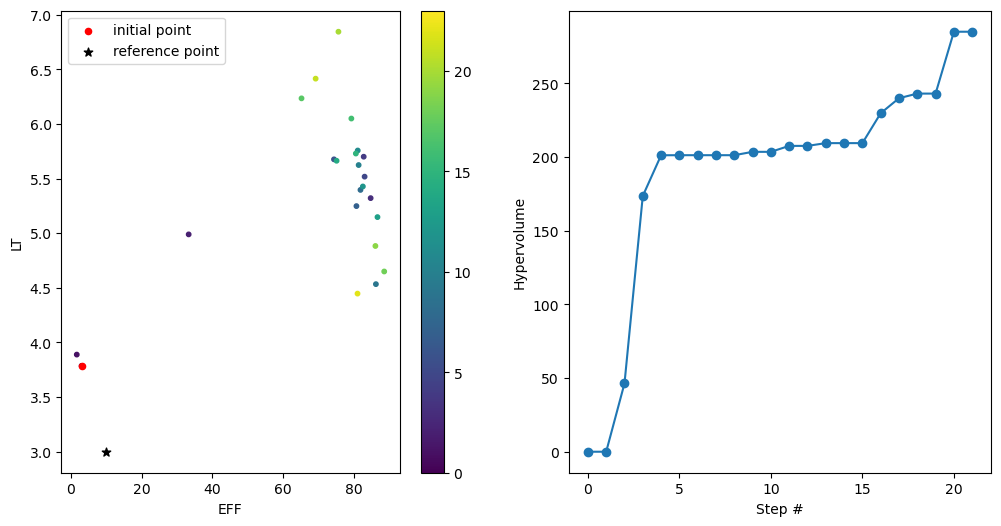

In [17]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

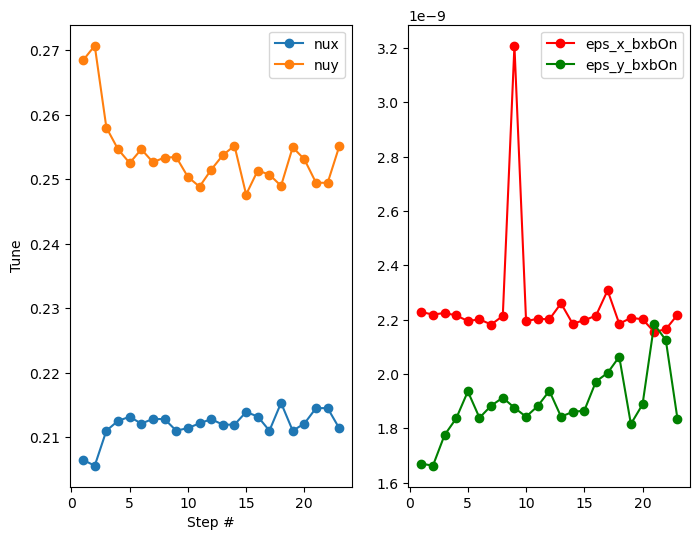

In [18]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [19]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_exp_mobo_{MODE}_v1_dump.json')

'{\n  "optimizer": {\n    "tag": "3d9b04d587",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_mobo",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "mobo_model",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": [],\n      "use_high_noise_prior": false\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 128,\n      "n_restarts": 10,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "reference_point": {\n      "LT": 3.0,\n      "EFF": 10.0\n    },\n    "prune_inferior_points_kwargs": null\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "igno